#### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns
from matplotlib.pyplot import cm
import warnings
warnings.filterwarnings('ignore')

from ml4proflow_mods.ina.data_segmentation.data_segmentation import DataSegmentation

#### Visualization helper functions

In [2]:
# Helper functions for plotting
def plot_marked_data(segmenter) -> widgets:
    """Function that plots the current segmenter train data, color coded by segments created by the segmenter.

    Returns:
        A widget containing the plot of the current segmenter train data, color coded by segment
    """
    patterns_plt = np.sort(segmenter.data['period'].unique())

    rgb_values = sns.color_palette("Set2", len(patterns_plt))
    color_map = dict(zip(patterns_plt, rgb_values))

    fig, ax = plt.subplots()
    indices = segmenter.data.index.to_numpy()
    ax.plot(indices, np.concatenate(segmenter.train_data, axis=0)[indices], color='black')
    for value in patterns_plt:
        if value == -1:
            pass
        else:
            indices = segmenter.data.index[segmenter.data['period'] == value].to_numpy()
            indices = indices[indices < np.concatenate(segmenter.train_data, axis=0).shape[0]]
            ax.plot(indices, np.concatenate(segmenter.train_data, axis=0)[indices], color=color_map[value])
    plt.xlabel("Time Step")
    plt.ylabel("Signal Value")
    plt.show()


In [3]:
def plot_found_patterns(patterns):
    patterns_plt = list(patterns.keys())
    if len(patterns_plt) < 1:
        return
    elif len(patterns_plt) == 1:
        plt.plot(patterns[patterns_plt[0]])
        return

    fig, axs = plt.subplots(1, len(patterns.keys()), sharex=True, sharey=True)

    for counter, pattern_number in enumerate(patterns_plt):
        axs[counter].plot(patterns[pattern_number])
    plt.show()

In [4]:
def plot_regex(signal_data, results):
    
    fig, ax = plt.subplots()
    for signal in signal_data.T:
        ax.plot(signal)

    res = results.sort_values(by=['rating'], ascending=False).reset_index()

    AMOUNT = 3
    if AMOUNT > res.shape[0]:
        AMOUNT = res.shape[0]

    color = cm.viridis(np.linspace(0, 1, AMOUNT))

    for i, c in zip(range(AMOUNT), color):
        spanStart = res['span_start'][i]
        spanStop = res['span_stop'][i]
        interval = res['interval'][i]

        v_lines = np.arange(spanStart, spanStop, interval)

        legend = False
        for line in v_lines:
            if not legend:
                plt.axvline(line, 0, 1, c=color[i], label='Interval: ' + str(interval))
                legend = True
            else:
                plt.axvline(line, 0, 1, c=color[i])

    legend = ax.legend(loc='upper right')
    
    plt.title('Regex recurring states')
    plt.ylabel("Scaled signal values")
    plt.xlabel("Time in ms")
    plt.legend(loc=3)
    plt.show()

## Data Segmentation
This notebook implements an example flow using the data segmentation module.
The goal of this module is to segment data in a sensible way, such that subsequent modules and processes can build on the automatically segmented data.

### Generate Data
The presented approach makes sense for data concerning to repeating processes, where additional information can be expected through comparing consecutive process iterations.
For this purpose, we generate an example Pandas Dataframe containing two simple repeating signals using the sine function:

<AxesSubplot:>

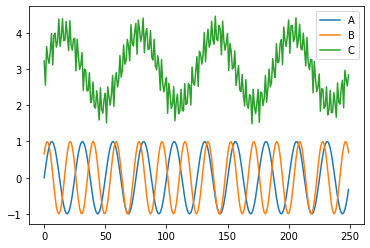

In [5]:
# Generate example data
x = np.linspace(0, 250, num=250)
data = pd.DataFrame(data=np.sin(x/4), index=None, columns=['A'])
data['B'] = np.sin(x/3 + 7)
data['C'] = np.sin(x/10) + 3 + (np.sin(x*2) / 10) + np.sin(x*3 + 2) / 6 + + np.sin(x*2 + 3) / 2

# Plot example data
data.plot()

At the moment, there are three different segmenting methods implemented:
- Find periodicities (-> segment by prominent frequency)
- Find peaks (-> segment at each peak in the input data)
- Find patterns (-> given a pattern, slice similar occurrences from the data)

### Find periodicities using FFT
For this method, a fast fourier transformation is used to identify occuring frequencies in the data. The rating is based on the relative peak height of a identified frequency, using the heighest peak as a basis.

In [6]:
# Find periodicities for A
segmenter = DataSegmentation(dataframe=data)
segmenter.set_training_data(['A'])

periodicities, ratings = segmenter.find_periodicities(method='FFT', method_params={})
print('Identified periodicities: {} \nCorresponding ratings: {}'.format(periodicities, list(ratings)))

Identified periodicities: [25] 
Corresponding ratings: [100.0]


In order to mark the slices in the original data, the method mark_in_data() is called with the desired periodicity. This method adds a column called period to the data, which counts up the current slice. This can be seen in the plot below:

          A         B         C  period
0  0.000000  0.656987  3.222110     0.0
1  0.248377  0.868162  2.553279     0.0
2  0.481187  0.983003  3.621503     0.0
3  0.683840  0.988766  3.299544     0.0
4  0.843634  0.884812  3.155656     0.0


<AxesSubplot:>

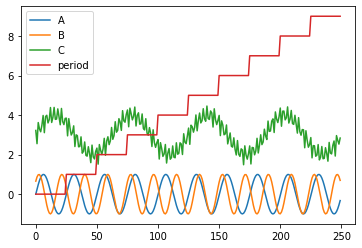

In [7]:
res_df = segmenter.mark_in_data('periodicities', {'periodicity': 25})
print(res_df.head())
res_df.plot()

The slices can also be plottet in different colours using the helper function defined above as plot_marked_data().

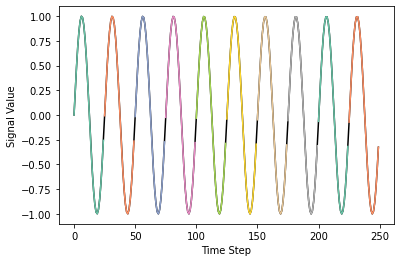

In [8]:
plot_marked_data(segmenter)

### Find periodicities using regular expressions
This method searches for recurring states in a discretized version of the signal. The occurring periodicities are then again rated using the relative fft data peak heights.

In [32]:
segmenter.set_training_data(['A'])
res = segmenter.find_periodicities(method='REGEX', method_params={'min_period': 2, 'n_segments': 5, 'verbose': False, 'range_tolerance': 2})
print(res)

  symbol interval n_periods span span_start span_stop data_length rating
0      0        3         4  5.0       17.0      22.0       250.0      0
1      1        3         3  3.0       14.0      17.0       250.0      0
2      4        3         4  5.0        4.0       9.0       250.0      0
3      3        3         3  3.0        9.0      12.0       250.0      0
4      2        3         3  3.0       24.0      27.0       250.0      0


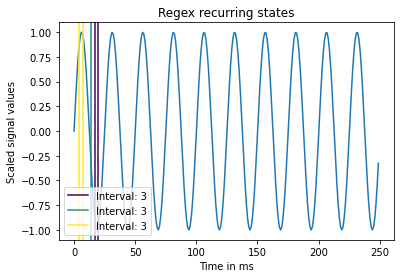

In [33]:
plot_regex(segmenter.train_data, res)

### Find peaks
The data can also be segmented by using the function find_peaks(), which takes as parameters the minimum peak height and minimum peak distance, where 0 is defined as using the default values.

In [11]:
# Find peaks in A
segmenter = DataSegmentation(dataframe=data)
segmenter.set_training_data(['A'])

peaks = segmenter.find_peaks(0, 0)

By again using the mark_in_data() method, the column period is added, marking one slice as lasting from one peak to the next.

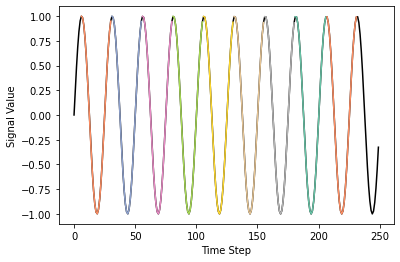

In [12]:
res_df = segmenter.mark_in_data('peaks')
plot_marked_data(segmenter)

### Find patterns
This workflow enables the user to:
1. Identify different patterns (of a given length) in the data by searching for high deviations from a signal's baseline (or zero) and clustering these
2. Calling set_pattern() and find_pattern() to identify similar occurences of a chosen pattern through autocorrelation
3. Mark these occurences in the data

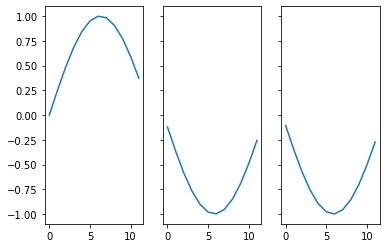

In [13]:
# Identify different patterns in the data
segmenter = DataSegmentation(dataframe=data)
segmenter.set_training_data(['A'])

exp_patterns = segmenter.identify_patterns(pattern_length=12, num_patterns=3, start_with_zero=True)
plot_found_patterns(exp_patterns)

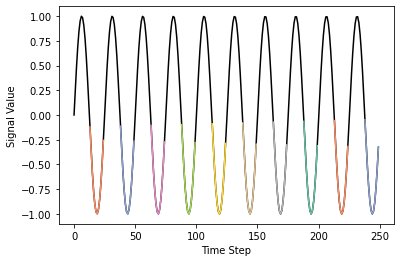

In [14]:
# Call set_pattern() to set a pattern (here the middle one) of interest and find_pattern() to identify occurences
segmenter.set_pattern(exp_patterns[1])
segmenter.find_pattern()

res_df = segmenter.mark_in_data('patterns')
plot_marked_data(segmenter)

### Generating the config and automated workflows
When a workflow is established by using one of the above methods to segment the data, the function save_to_config() can be called to add it to a config. Write_config converts this configuration to a .json file and writes it under the name data_segmentation_config.json in the current working directory.

In [15]:
segmenter.save_to_config()
file_name = segmenter.write_config()

To run a workflow automatically, a new DataSegmentation object is created. Given data and a config, the method run() can be called, which returns the processed dataframe.

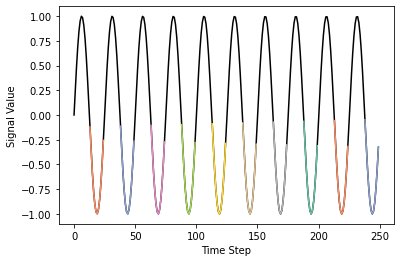

In [16]:
segmenter = DataSegmentation(dataframe=data)
segmenter.set_config(file_name)
res_df = segmenter.run()
res_df.head()
plot_marked_data(segmenter)